In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, os

%matplotlib inline
working_directory = os.getcwd()

In [2]:
# import the encoded covid df
encoded_df = pd.read_csv(working_directory + '/VAERSData/encoded_df.csv')
encoded_df.shape

(436116, 20)

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
features_cols = encoded_df.columns.drop('RECOVD')

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(strat_shuf_split.split(encoded_df[features_cols], encoded_df.RECOVD))
X_train = encoded_df.loc[train_idx, features_cols]
y_train = encoded_df.loc[train_idx, 'RECOVD']

X_test  = encoded_df.loc[test_idx, features_cols]
y_test  = encoded_df.loc[test_idx, 'RECOVD']

In [5]:
y_train.value_counts(normalize=True) 

0    0.512416
1    0.487584
Name: RECOVD, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

0    0.512416
1    0.487584
Name: RECOVD, dtype: float64

> - Use GridSearchCV to examine the best hyperparameter.
> - Fit a logistic regression model without any regularization using all of the features.
> - Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations.


In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [8]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'penalty': ['l1','l2','elasticnet','none'],
              'C': np.logspace(-4, 4, 20),
               'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
               'max_iter': [100, 1000, 3000, 5000]}

# The grid search object
#GV_LR = GridSearchCV(lr, cv=4,
#                 param_grid= param_grid,
#                 verbose=True,
#                n_jobs=-1)

# Do the grid search
#GV_LR = GV_LR.fit(X_train, y_train)


In [168]:
GV_LR_best = GV_LR.best_estimator_
GV_LR_best

LogisticRegression(C=0.0018329807108324356, solver='liblinear')

> - Fit the solver:liblinear again with different penalties

In [8]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [9]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression

lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [10]:
# L2 regularized logistic regression

lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.

In [185]:
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [1]], codes=[[0], [0]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))
    
coefficients = pd.concat(coefficients, axis=1)
coefficients.shape #.sample(10)

(19, 3)

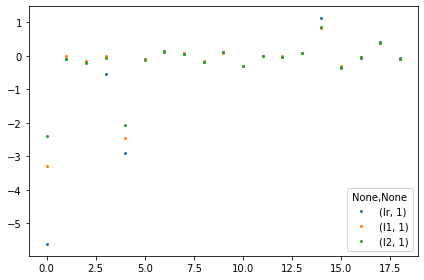

In [183]:
# Plot Models Coeeficients
coefficients.plot(marker='o', ls='', ms=2.0, legend=True)

ax.set(title='Coefficient Set '+str(1))
    
plt.tight_layout()

Predict and store the class for each model,* Store the probability for the predicted class for each model.

In [155]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr','l1','l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    coeff_label= pd.MultiIndex(levels=[[lab], [1]],
                               codes=[[0], [0]])
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1) 
y_pred.head()

,lr,l1,l2
0,1,1,1
1,1,1,1
2,0,0,0
3,0,0,0
4,1,1,1


the prediction values of recovery looks the same for the three models. we can examine the values that were different tho.

In [156]:
y_pred[y_pred.lr != y_pred.l1]

,lr,l1,l2
67,1,0,0
115,1,0,0
144,1,0,1
147,0,1,1
169,0,1,1
...,...,...,...
130284,1,0,0
130297,1,0,0
130538,0,1,0
130568,1,0,0


In [157]:
y_prob.head()

,lr,l1,l2
0,0.564768,0.564245,0.564342
1,0.613501,0.609420,0.611260
2,0.638694,0.627303,0.632741
3,0.543685,0.542915,0.543530
4,0.554836,0.551876,0.552265


For each model, calculate the following error metrics: 
    Accuracy,
    Precision,
    Recall,
    F-score,
    Confusion Matrix,
    Decide how to combine the multi-class metrics into a single value for each model.

In [158]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:
    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
                  label_binarize(y_pred[lab], classes=[0,1]),
                  average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                              'fscore':fscore, 'accuracy':accuracy,
                               'auc':auc}, 
                               name=lab))
metrics = pd.concat(metrics, axis=1)
metrics

,lr,l1,l2
precision,0.583313,0.583576,0.584155
recall,0.583582,0.583888,0.584469
fscore,0.583247,0.583339,0.583874
accuracy,0.583582,0.583888,0.584469
auc,0.582865,0.582987,0.583533


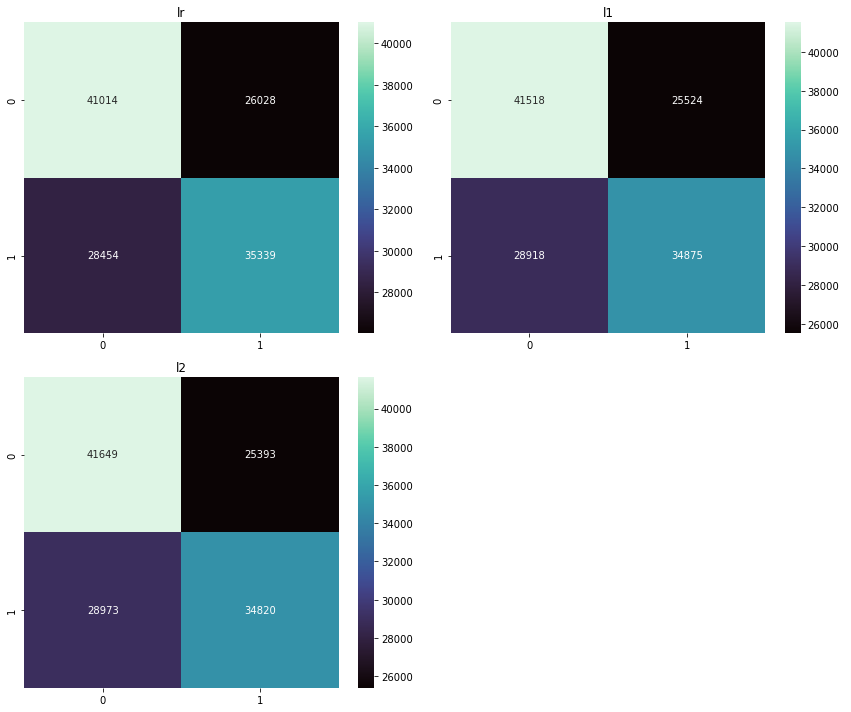

In [164]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)
    
axList[-1].axis('off')
    
for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap='mako')
    ax.set(title=lab)
    
plt.tight_layout()

# -------------------------------------------------------------------------------------------